## collect the pairs from huintaf and our colabfold

In [46]:
from pathlib import Path
from Bio import SeqIO
import pandas as pd

from ppi_utils.reduce import dedup_pairs
from ppi_utils.general import to_fasta, to_lines, get_ids
from ppi_utils.api import uniprot_api_fetch

In [47]:
h2 = pd.read_csv('../huintaf2_scores.tsv', sep='\t', header=0)
len(h2)

68363

In [48]:
h2.head()

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod,capri
0,A0A024R0Y4,O14964,0.077304,HuRI,ENSG00000185359-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-DD64167A19DCF030,11.84117,6.937132,0.158014,0.516088,6.937132,0.516088,11.841170,9.389151,incorrect
1,A0A024R0Y4,O15287,0.038752,HuRI,ENSG00000221829-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-4BC7475472AC3C84,11.84117,11.711823,0.158014,0.127010,11.711823,0.158014,11.841170,11.776496,incorrect
2,A0A024R0Y4,O60573,0.034888,HuRI,ENSG00000135930-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-3D3075BFA48B3C12,11.84117,9.707791,0.158014,0.334694,9.707791,0.334694,11.841170,10.774480,incorrect
3,A0A024R0Y4,O75431,0.075548,HuRI,ENSG00000128654-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-3A2EF476F1C78465,11.84117,12.701179,0.158014,0.087452,11.841170,0.158014,12.701179,12.271174,incorrect
4,A0A024R0Y4,O75528,0.730883,HuRI,ENSG00000171148-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-C86153CFA83F9226,11.84117,8.649690,0.158014,0.388889,8.649690,0.388889,11.841170,10.245430,medium


In [49]:
h2.dataset.value_counts()

HuRI            55439
hu.MAP          10045
1849 random      1849
516 HuRI $+$      516
514 HuRI $-$      514
Name: dataset, dtype: int64

In [50]:
pairs = h2[['hash_A', 'hash_B']].copy()
len(pairs), len(pairs := dedup_pairs(pairs))

(68363, 67307)

In [51]:
pairs.head()

,hash_A,hash_B
0,CRC-27D3F4F4D5EFF3C8,CRC-DD64167A19DCF030
1,CRC-27D3F4F4D5EFF3C8,CRC-4BC7475472AC3C84
2,CRC-27D3F4F4D5EFF3C8,CRC-3D3075BFA48B3C12
3,CRC-27D3F4F4D5EFF3C8,CRC-3A2EF476F1C78465
4,CRC-27D3F4F4D5EFF3C8,CRC-C86153CFA83F9226


## write a TSV and a FASTA

In [52]:
pairs.to_csv('test.tsv', sep='\t', header=False, index=False)

In [53]:
seqs = {r.id : str(r.seq) for r in SeqIO.parse('../uniprot/huintaf.hash.fasta', 'fasta')} | {r.id : r.seq for r in SeqIO.parse('../../ppi_data/v2.1/1:1_small/huri_test.fasta', 'fasta')}
len(seqs), next(iter(seqs.items()))

(9975,
 ('CRC-27D3F4F4D5EFF3C8',
  'MDRLGSFSNDPSDKPPCRGCSSYLMEPYIKCAECGPPPFFLCLQCFTRGFEYKKHQSDHTYEIMTSDFPVLDPSWTAQEEMALLEAVMDCGFGNWQDVANQMCTKTKEECEKHYMKHFINNPLFASTLLNLKQAEEAKTADTAIPFHSTDDPPRPTFDSLLSRDMAGYMPARADFIEEFDNYAEWDLRDIDFVEDDSDILHALKMAVVDIYHSRLKERQRRKKIIRDHGLINLRKFQLMERRYPKEVQDLYETMRRFARIVGPVEHDKFIESHALEFELRREIKRLQEYRTAGITNFCSARTYDHLKKTREEERLKRTMLSEVLQYIQDSSACQQWLRRQADIDSGLSPSIPMASNSGRRSAPPLNLTGLPGTEKLNEKEKELCQMVRLVPGAYLEYKSALLNECNKQGGLRLAQARALIKIDVNKTRKIYDFLIREGYITKG'))

In [54]:
_ids = get_ids(pairs)
len(_ids), _ids - seqs.keys()

(9973, set())

In [55]:
with open('test.fasta', 'w') as fasta:
    for _id in sorted(seqs):
        to_fasta(_id, seqs[_id], fasta)

## run the predictor script

```bash
#!/bin/bash -e
set -x
source /mnt/lsf-nas-1/os-shared/anaconda3/etc/profile.d/conda.sh
conda activate kaindl_ppi

ppi embed --fasta test.fasta --h5-file huintaf.h5 --h5-mode a --cache-dir "/mnt/project/kaindl/ppi/embed_data/t5_xl_weights"

rostclust uniqueprot2d --hval-config-path "/mnt/project/kaindl/ppi/ppi_data/hval_config.json" test.fasta "/mnt/project/kaindl/ppi/ppi_data/v2.1/1:1_small/apid_train.fasta" test_c3.fasta

ppi predict --model "/mnt/project/kaindl/ppi/runs/23/s23acc/chk_39.tar" --in-tsv test.tsv --out-tsv predict.tsv --no-header --h5 huintaf.h5 --mode w
```

## load the results

In [56]:
preds = pd.read_csv(
    'predict.tsv', sep='\t', header=None,
    names=['hash_A', 'hash_B', 'p_hat'])
preds.head()

,hash_A,hash_B,p_hat
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,0.4120
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,0.4734
2,CRC-001576EA78C61C85,CRC-2743716544288776,0.2539
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,0.8658
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,0.7002


In [77]:
h3 = pd.merge(h2, preds, on=['hash_A', 'hash_B'])
len(h3)

35121

In [78]:
h3.head()

,ida,idb,pdockq,dataset,pdbfile,prob,hash_A,hash_B,za,zb,da,db,min_chezod,max_diso,max_chezod,avg_chezod,capri,p_hat
0,A0A024R0Y4,O14964,0.077304,HuRI,ENSG00000185359-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-DD64167A19DCF030,11.84117,6.937132,0.158014,0.516088,6.937132,0.516088,11.841170,9.389151,incorrect,0.7727
1,A0A024R0Y4,O15287,0.038752,HuRI,ENSG00000221829-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-4BC7475472AC3C84,11.84117,11.711823,0.158014,0.127010,11.711823,0.158014,11.841170,11.776496,incorrect,0.6821
2,A0A024R0Y4,O60573,0.034888,HuRI,ENSG00000135930-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-3D3075BFA48B3C12,11.84117,9.707791,0.158014,0.334694,9.707791,0.334694,11.841170,10.774480,incorrect,0.3145
3,A0A024R0Y4,O75431,0.075548,HuRI,ENSG00000128654-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-3A2EF476F1C78465,11.84117,12.701179,0.158014,0.087452,11.841170,0.158014,12.701179,12.271174,incorrect,0.7614
4,A0A024R0Y4,O75528,0.730883,HuRI,ENSG00000171148-ENSG00000276234.pdb,1.0,CRC-27D3F4F4D5EFF3C8,CRC-C86153CFA83F9226,11.84117,8.649690,0.158014,0.388889,8.649690,0.388889,11.841170,10.245430,medium,0.7397


In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import matplotlib as mpl
from ppi_utils.general import to_lines
%matplotlib inline

In [80]:
# !mkdir -p plots

In [81]:
sns.set_theme(style='ticks')
mpl.rcParams['figure.facecolor'] = 'none'
mpl.rcParams['legend.frameon'] = False
h = 3  # plot height
capris = ['incorrect', 'acceptable', 'medium', 'high']
num_capris = ['$< 0.23$', '$0.23 - 0.5$', '$> 0.5$']

l, m, r = sns.color_palette('crest', 7)[0::3]
pal = [l, r]

In [82]:
sets = list(h2.dataset.unique())
sets = sets[3:] + sets[:3]
sets

['516 HuRI $+$', '514 HuRI $-$', 'HuRI', 'hu.MAP', '1849 random']

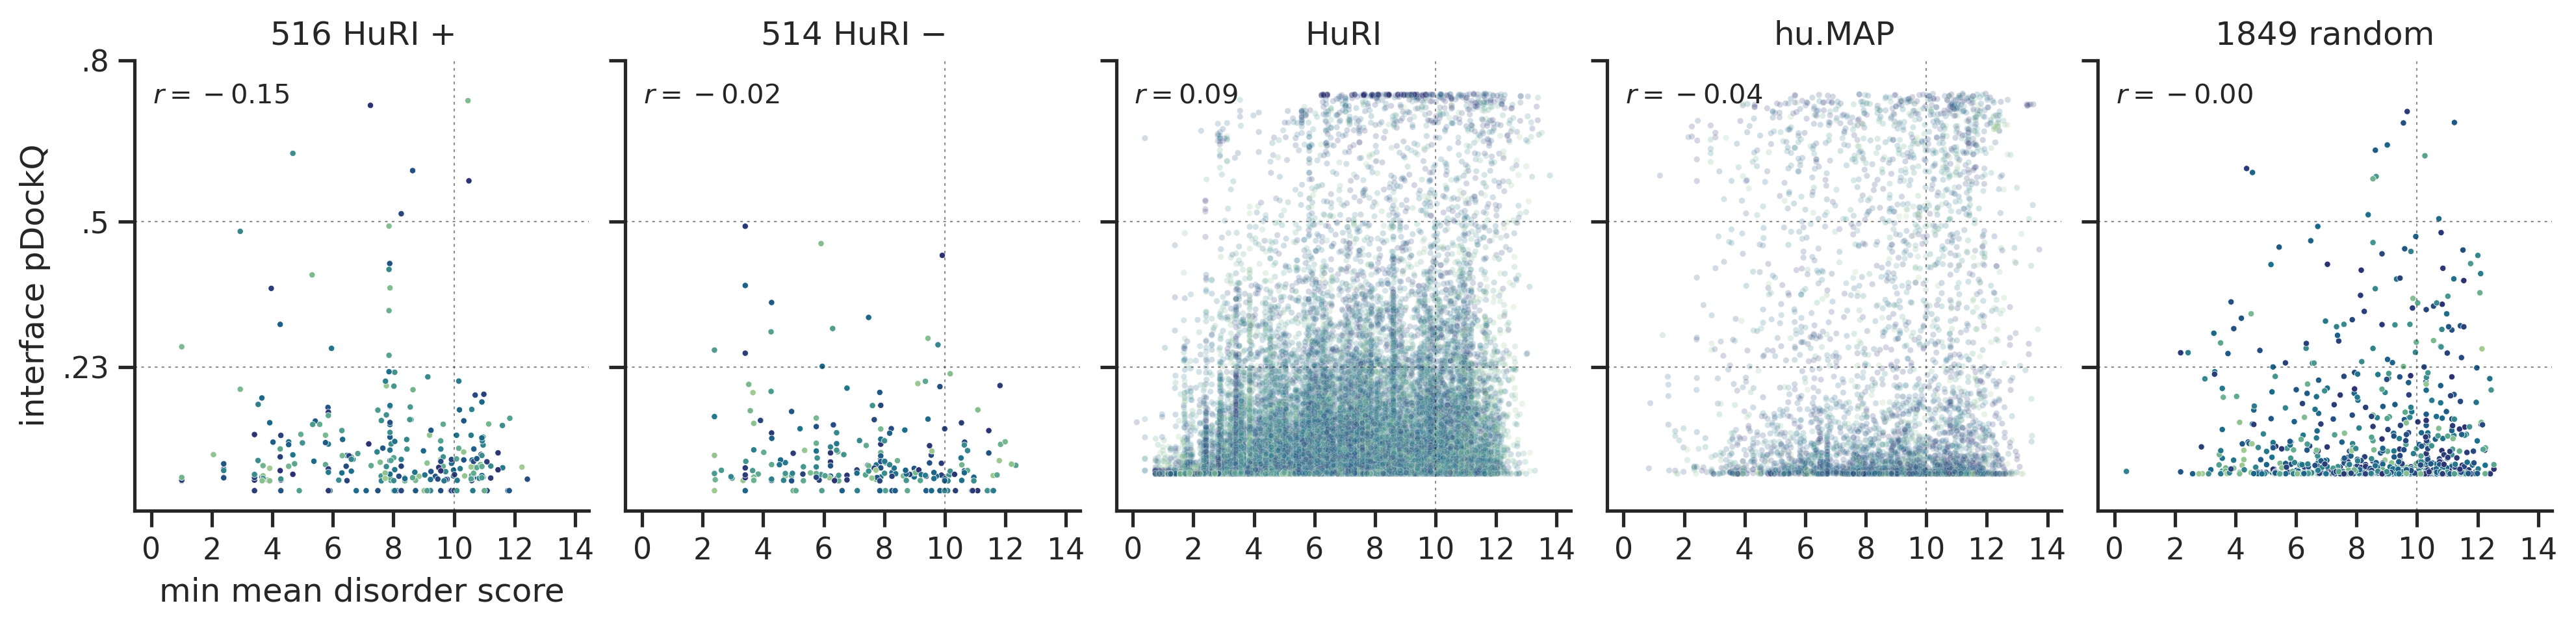

In [84]:
from matplotlib.ticker import MaxNLocator

with mpl.rc_context({'figure.dpi': 300}):
    fig, axes = plt.subplots(nrows=1, ncols=len(sets),
                             figsize=(3.2 * len(sets), 3),
                             sharex=True, sharey=True)
    shrink = ['HuRI', 'hu.MAP']
    for j, (_set, ax) in enumerate(zip(sets, axes)):
        df = h3.loc[(h3.dataset == _set) & (~h3.p_hat.isna())]
        sn = sns.scatterplot(
            data=df,
            y='pdockq',
            x='min_chezod',
            hue='p_hat', palette='crest', hue_norm=(0, 1),
            s=5,
            alpha=1 if _set not in shrink else .2,
            ax=ax,
            legend=False,
            rasterized=_set in shrink,
        )
        ax.set(title=_set, yticks=[.23, .5, .8], yticklabels=['.23', '.5', '.8'], ylabel=None, xlabel=None)
        for l in [.23, .5]:
            kw = dict(dashes=(2, 3), c='.1', lw=.5, alpha=.5, zorder=99)
            ax.axhline(y=l, **kw)
        ax.axvline(x=10, **kw)
        if not j:
            ax.set(xlabel='min mean disorder score', ylabel='interface pDockQ')
        rho = spearmanr(df.pdockq, df.p_hat)[0]
        ax.text(.04, .95, f'$r = {rho:.2f}$', ha='left', va='top', fontsize='small', transform=ax.transAxes)
        # if _set == 'hu.MAP':
        #     rho = spearmanr(df.pdockq, df.prob)[0]
        #     ax.text(.04, .01, f'Spearman\'s $r = {rho:.2f}$', ha='left', va='bottom', fontsize='xx-small', transform=ax.transAxes)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.subplots_adjust(wspace=.08)
    sns.despine()
    fig.savefig('chezod_s23acc.pdf')

In [85]:
spearmanr(h3.prob, h3.p_hat)

SignificanceResult(statistic=-0.10509459364399068, pvalue=8.123584278670354e-87)

In [86]:
spearmanr(h3.pdockq, h3.p_hat)

SignificanceResult(statistic=0.05180868155745606, pvalue=2.591388439402072e-22)